<a href="https://colab.research.google.com/github/rahmed12/stockPrediction/blob/master/stockPredict_classWork_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#some code taken from https://enlight.nyc/projects/stock-market-prediction/
#!pip install sklearn

In [0]:
## Further  recommendation, test multiple frameworks, see what works better on average. 
## Open source RL: https://docs.google.com/spreadsheets/d/1EeFPd-XIQ3mq_9snTlAZSsFY7Hbnmd7P5bbT8LPuMn0/edit#gid=0

import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import datetime
from pandas import Series, DataFrame

import math

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge, LassoLars, BayesianRidge
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split


start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2019, 4, 9)

df = web.DataReader("AAPL", 'yahoo', start, end)
#df.tail()


# features: High Low Percentage and Percentage Change.
dfreg = df.loc[:, ['Adj Close', 'Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

dfreg.tail()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2019-04-03,193.864029,23271800.0,1.714874,1.086678
2019-04-04,194.201431,19114300.0,1.650568,0.462041
2019-04-05,195.501465,18526600.0,0.593915,0.279971
2019-04-08,198.577881,25881700.0,1.944028,1.873540
2019-04-09,197.982452,35768200.0,1.814542,-0.409349


In [0]:
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)

# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))

# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)


X = np.array(dfreg.drop(['label'], 1))


# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)



# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]

X = X[:-forecast_out]

# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]



/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [0]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)

# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

# LARS Lasso
cllasso = LassoLars(alpha=.1)
cllasso.fit(X_train, y_train)

# Bayesain ridge reg
clbay = BayesianRidge()
clbay.fit(X_train, y_train)



BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, tol=0.001, verbose=False)

In [0]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)
confidencelasso = cllasso.score(X_test, y_test)
confidencebay = clbay.score(X_test, y_test)

print("confidencereg: ", confidencereg)
print("confidencepoly2: ", confidencepoly2)
print("confidencepoly3: ", confidencepoly3)
print("confidenceknn: ", confidenceknn)
print("confidencelasso: ", confidencelasso)
print("confidencebay: ", confidencebay)

confidencereg:  0.9705512358255477
confidencepoly2:  0.9722233150146682
confidencepoly3:  0.9722456257916527
confidenceknn:  0.9527049333059894
confidencelasso:  0.9638272517809163
confidencebay:  0.9705519207279028


In [0]:
# change prediction here
forecast_set = clfreg.predict(X_lately)
dfreg['Forecast'] = np.nan

forecast_set_poly2 = clfpoly2.predict(X_lately)
dfreg['Forecast_poly2'] = np.nan

forecast_set_poly3 = clfpoly3.predict(X_lately)
dfreg['Forecast_poly3'] = np.nan

forecast_set_knn = clfknn.predict(X_lately)
dfreg['Forecast_knn'] = np.nan

forecast_set_lasso = cllasso.predict(X_lately)
dfreg['Forecast_lasso'] = np.nan

forecast_set_bay = clbay.predict(X_lately)
dfreg['Forecast_bay'] = np.nan

#print (dfreg['Forecast_poly2'])

# sanity check
#print(forecast_set)




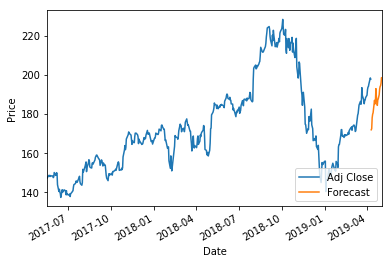

In [0]:

last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)


for (i, p2, p3, knn, lasso, bay) in zip(forecast_set, forecast_set_poly2, forecast_set_poly3, forecast_set_knn, forecast_set_lasso, forecast_set_bay):
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    #dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)- 1 )] + [i] 
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)) ] 
    dfreg.loc[next_date, ['Forecast']] = [i]
    dfreg.loc[next_date, ['Forecast_poly2']] = [p2]
    dfreg.loc[next_date, ['Forecast_poly3']] = [p3]
    dfreg.loc[next_date, ['Forecast_knn']] = [knn]
    dfreg.loc[next_date, ['Forecast_lasso']] = [lasso]
    dfreg.loc[next_date, ['Forecast_bay']] = [bay]
    

dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


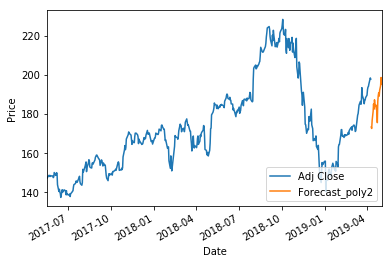

In [0]:
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast_poly2'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


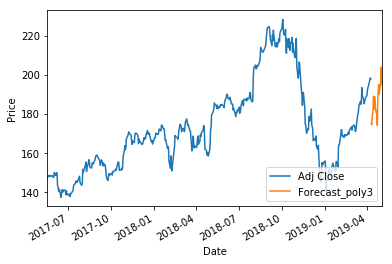

In [0]:
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast_poly3'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


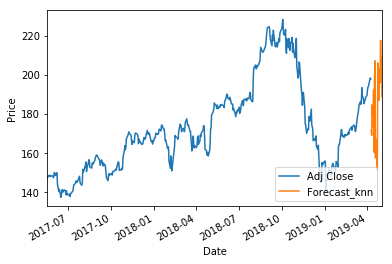

In [0]:
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast_knn'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


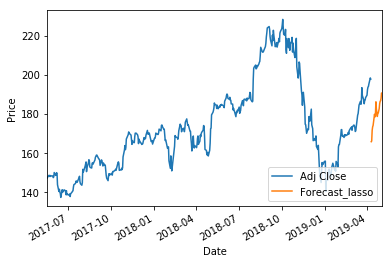

In [0]:
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast_lasso'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


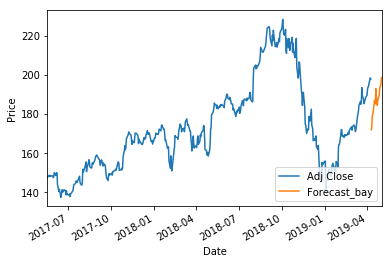

In [0]:
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast_bay'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()